# Q2: Lets go deeper! CaffeNet for PASCAL classification (20 pts)

**Note:** You are encouraged to reuse code from the previous task. Finish Q1 if you haven't already!


As you might have seen, the performance of the SimpleCNN model was pretty low for PASCAL. This is expected as PASCAL is much more complex than FASHION MNIST, and we need a much beefier model to handle it.

In this task we will be constructing a variant of the [AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) architecture, known as CaffeNet. If you are familiar with Caffe, a prototxt of the network is available [here](https://github.com/BVLC/caffe/blob/master/models/bvlc_reference_caffenet/train_val.prototxt). A visualization of the network is available [here](http://ethereon.github.io/netscope/#/preset/caffenet).


## 2.1 Build CaffeNet (5 pts)
Here is the exact model we want to build. In this task, `torchvision.models.xxx()` is NOT allowed. Define your own CaffeNet! We use the following operator notation for the architecture:
1. Convolution: A convolution with kernel size $k$, stride $s$, output channels $n$, padding $p$ is represented as $conv(k, s, n, p)$.
2. Max Pooling: A max pool operation with kernel size $k$, stride $s$ as $maxpool(k, s)$.
3. Fully connected: For $n$ output units, $FC(n)$.
4. ReLU: For rectified linear non-linearity $relu()$

```
ARCHITECTURE:
-> image
-> conv(11, 4, 96, ’VALID’)
-> relu()
-> max_pool(3, 2)
-> conv(5, 1, 256, 'SAME')
-> relu()
-> max_pool(3, 2)
-> conv(3, 1, 384, 'SAME')
-> relu()
-> conv(3, 1, 384, 'SAME')
-> relu()
-> conv(3, 1, 256, ’SAME’)
-> relu()
-> max_pool(3, 2)
-> flatten()
-> fully_connected(4096)
-> relu()
-> dropout(0.5)
-> fully_connected(4096)
-> relu()
-> dropout(0.5)
-> fully_connected(20)
```

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline

import trainer
from utils import ARGS
from simple_cnn import SimpleCNN
from voc_dataset import VOCDataset


class CaffeNet(nn.Module):
    def __init__(self, num_classes=20, size=227, c_dim=3):
        super().__init__()
        self.num_classes = num_classes
        # size
        self.conv1 = nn.Conv2d(c_dim, 96, 11, 4)
        # size is 55
        self.conv2 = nn.Conv2d(96 , 256, 5, 1, padding=2)
        self.conv3 = nn.Conv2d(256, 384, 3, 1, padding=1)
        self.conv4 = nn.Conv2d(384, 384, 3, 1, padding=1)
        self.conv5 = nn.Conv2d(384, 256, 3, 1, padding=1)
        
        map_size = (size - 11) / 4 + 1
        map_size = (((map_size - 1)/ 2 - 1) / 2 - 1) / 2
        self.flat_dim = int(map_size**2 * 256)
        
        self.nonlinear = nn.ReLU()
        self.pool1 = nn.MaxPool2d(3,2)
        self.pool2 = nn.MaxPool2d(3,2)
        self.pool3 = nn.MaxPool2d(3,2)
        
        self.dropout = nn.Dropout(p=0.5)
        
        self.fc1 = nn.Linear(self.flat_dim, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)
        
        self.backbone = nn.Sequential()
        
    def backbone(self, x):
        x = self.conv1(x)
        x = self.nonlinear(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.nonlinear(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.nonlinear(x)
        x = self.conv4(x)
        x = self.nonlinear(x)
        x = self.conv5(x)
        x = self.nonlinear(x)
        x = self.pool3(x)
        x = x.view(-1, self.flat_dim)
        return x
    
    def classifier(self, x):
        x = self.fc1(x)
        x = self.nonlinear(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.nonlinear(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    
    def tsne_features(self, x):
        x = self.backbone(x)
        x = self.fc1(x)
        x = self.nonlinear(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    def forward(self, x):
        features = self.backbone(x)
        out = self.classifier(features)
        return out

## 2.2 Save the Model (5 pts)
Finish code stubs for saving the model periodically into trainer.py. **You will need these models later**


## 2.3 Train and Test (5pts)
Show clear screenshots of testing MAP and training loss for 50 epochs. Please evaluate your model to calculate the MAP on the testing dataset every 250 iterations. Use the following hyperparamters:
* batch_size=32
* Adam optimizer with lr=0.0001

**NOTE: SAVE AT LEAST 5 EVENLY SPACED CHECKPOINTS DURING TRAINING (1 at end)**

In [6]:
# args = ARGS(batch_size=32, test_batch_size=32, epochs=50, val_every=250, lr=1e-4, size=227, save_freq=10)
# model = CaffeNet()
# optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=args.gamma)
# test_ap, test_map = trainer.train(args, model, optimizer, scheduler, model_name = 'runs/q2/model')
# print('test map:', test_map)

**INSERT YOUR TENSORBOARD SCREENSHOTS HERE**

![title](imgs/q2_tb_map.png)
![title](imgs/q2_tb_loss.png)


## 2.4 Visualizing: Conv-1 filters (5pts)
Extract and compare the conv1 filters, at different stages of the training (at least from 3 different iterations). Show at least 5 filters.

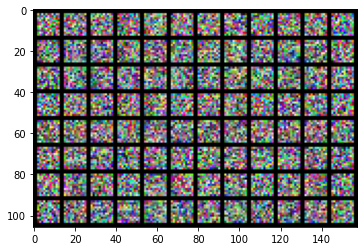

In [7]:
# visualize below
state_dict = torch.load('runs/q2/model_10.pt')
weights = state_dict['conv1.weight'].cpu()
n,c,h,w = weights.shape
weights_flat = weights.view(n,c,h*w)
weights_min = torch.unsqueeze(weights_flat.min(-1)[0], 2)
weights_flat = weights_flat - weights_min
weights_norm = torch.unsqueeze(weights_flat.max(-1)[0], 2)
weights_disp = weights_flat/weights_norm
weights_disp = weights_disp.view_as(weights)
grid_img = torchvision.utils.make_grid(weights_disp, nrow=12)
plt.imshow(grid_img.permute(1,2,0))
plt.show()

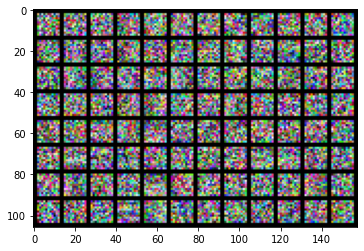

In [8]:
state_dict = torch.load('runs/q2/model_30.pt')
weights = state_dict['conv1.weight'].cpu()
n,c,h,w = weights.shape
weights_flat = weights.view(n,c,h*w)
weights_min = torch.unsqueeze(weights_flat.min(-1)[0], 2)
weights_flat = weights_flat - weights_min
weights_norm = torch.unsqueeze(weights_flat.max(-1)[0], 2)
weights_disp = weights_flat/weights_norm
weights_disp = weights_disp.view_as(weights)
grid_img = torchvision.utils.make_grid(weights_disp, nrow=12)
plt.imshow(grid_img.permute(1,2,0))
plt.show()

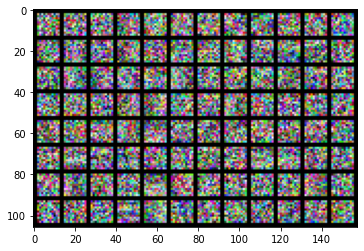

In [9]:
state_dict = torch.load('runs/q2/model_49.pt')
weights = state_dict['conv1.weight'].cpu()
n,c,h,w = weights.shape
weights_flat = weights.view(n,c,h*w)
weights_min = torch.unsqueeze(weights_flat.min(-1)[0], 2)
weights_flat = weights_flat - weights_min
weights_norm = torch.unsqueeze(weights_flat.max(-1)[0], 2)
weights_disp = weights_flat/weights_norm
weights_disp = weights_disp.view_as(weights)
grid_img = torchvision.utils.make_grid(weights_disp, nrow=12)
plt.imshow(grid_img.permute(1,2,0))
plt.show()